In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None  # show all columns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import RidgeCV
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

## I. Read Data

In [4]:
airline_data = pd.read_csv('../data/dataset/airline.csv')
group_data = pd.read_csv('../data/dataset/group.csv')
order_data = pd.read_csv('../data/dataset/order.csv')
day_schedule_data = pd.read_csv('../data/dataset/day_schedule.csv')
column_names = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 
              'Altitude', 'Timezone', 'DST', 'TZ', 'Type','Source']
df_airport = pd.read_csv('../data/airport.csv', names=column_names) # from open data; ref: https://openflights.org/data.html#airport

# test and train data
train_data = pd.read_csv('../data/training-set.csv')
test_data = pd.read_csv('../data/testing-set.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## II. Feature Engineering

### 1. Derive Order Related Variables  

In [5]:
order_data['order_date_dt'] = pd.to_datetime(order_data.order_date, format='%d-%b-%y') # ref: http://strftime.org/
order_data['order_year'] = order_data.order_date_dt.dt.year
order_data['order_month'] = order_data.order_date_dt.dt.month
order_data['order_day'] = order_data.order_date_dt.dt.day
order_data['order_dayofyear'] = order_data.order_date_dt.dt.dayofyear
order_data['order_weekday'] = order_data.order_date_dt.dt.dayofweek # 0=Mon, 6=Sun
order_data['unit']=order_data.unit.str.replace('unit_value_', '')
order_data['source_1']=order_data.source_1.str.replace('src1_value_', '')
order_data['source_2']=order_data.source_2.str.replace('src2_value_', '')
order_data['group_id'] = order_data['group_id'].apply(str)

In [6]:
order_data.head()

,order_id,group_id,order_date,source_1,source_2,unit,people_amount,order_date_dt,order_year,order_month,order_day,order_dayofyear,order_weekday
0,136100,63695,5-Jan-17,1,1,1,2,2017-01-05,2017,1,5,5,3
1,140370,63695,9-Nov-16,1,1,2,1,2016-11-09,2016,11,9,314,2
2,211009,63695,20-Jan-17,1,1,3,2,2017-01-20,2017,1,20,20,4
3,41571,53481,14-Mar-17,1,1,4,4,2017-03-14,2017,3,14,73,1
4,64125,53481,27-Mar-17,2,1,5,1,2017-03-27,2017,3,27,86,0


### 2. Derive Order Related Variables 

In [7]:
group_data['sub_line'] = group_data.sub_line.str.replace('subline_value_','')
group_data['area'] = group_data.area.str.replace('area_value_','')
group_data['begin_date_dt'] = pd.to_datetime(group_data.begin_date, format='%d-%b-%y')
group_data['begin_year'] = group_data.begin_date_dt.dt.year
group_data['begin_month'] = group_data.begin_date_dt.dt.month
group_data['begin_day'] = group_data.begin_date_dt.dt.day
group_data['begin_dayofyear'] = group_data.begin_date_dt.dt.dayofyear
group_data['begin_weekday'] = group_data.begin_date_dt.dt.dayofweek # 0=Mon, 6=Sun
group_data['end_date_dt'] = group_data.begin_date_dt + group_data['days'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
group_data['end_year'] = group_data.end_date_dt.dt.year
group_data['end_month'] = group_data.end_date_dt.dt.month
group_data['end_day'] = group_data.end_date_dt.dt.day
group_data['end_dayofyear'] = group_data.end_date_dt.dt.dayofyear
group_data['end_weekday'] = group_data.end_date_dt.dt.dayofweek # 0=Mon, 6=Sun

# add
group_data['pd_name_len'] = group_data.product_name.astype(str).apply(len)

In [8]:
group_data['pm1'] = group_data.promotion_prog.str.contains('早').fillna(False).astype(int)
group_data['pm2'] = group_data.promotion_prog.str.contains('送').fillna(False).astype(int)
group_data['pm3'] = group_data.promotion_prog.str.contains('限').fillna(False).astype(int)
group_data['pm4'] = group_data.promotion_prog.str.contains('亞').fillna(False).astype(int)
group_data['pm5'] = group_data.promotion_prog.str.contains('預').fillna(False).astype(int)
group_data['pm6'] = group_data.promotion_prog.str.contains('經典').fillna(False).astype(int)
group_data['pm7'] = group_data.promotion_prog.str.contains('無需').fillna(False).astype(int)
group_data['pm8'] = group_data.promotion_prog.str.contains('搶').fillna(False).astype(int)
group_data['pm9'] = group_data.promotion_prog.str.contains('飯店').fillna(False).astype(int)
group_data['pm10'] = group_data.promotion_prog.str.contains('超值').fillna(False).astype(int)
group_data['pm11'] = group_data.promotion_prog.str.contains('購物').fillna(False).astype(int)
group_data['pm12'] = group_data.promotion_prog.str.contains('山').fillna(False).astype(int)
group_data['pm13'] = group_data.promotion_prog.str.contains('海').fillna(False).astype(int)
group_data['pm13'] = group_data.promotion_prog.str.contains('北').fillna(False).astype(int)


group_data['pd1'] = group_data.product_name.str.contains('購物').fillna(False).astype(int)
group_data['pd2'] = group_data.product_name.str.contains('山').fillna(False).astype(int)
group_data['pd3'] = group_data.product_name.str.contains('海').fillna(False).astype(int)
group_data['pm13'] = group_data.product_name.str.contains('北').fillna(False).astype(int)

group_data['tax1'] = group_data.product_name.str.contains('稅').fillna(False).astype(int)
group_data['tax2'] = group_data.promotion_prog.str.contains('稅').fillna(False).astype(int)

In [9]:
group_data.head()

,group_id,sub_line,area,days,begin_date,price,product_name,promotion_prog,begin_date_dt,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_date_dt,end_year,end_month,end_day,end_dayofyear,end_weekday,pd_name_len,pm1,pm2,pm3,pm4,pm5,pm6,pm7,pm8,pm9,pm10,pm11,pm12,pm13,pd1,pd2,pd3,tax1,tax2
0,63695,1,1,12.0,22-Mar-17,106900.0,最高省8000》大美西～夏威夷、優勝美地、西峽天空步道、聖地牙哥、環球影城(哈利波特)12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53481,1,1,12.0,17-May-17,112900.0,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2017-05-17,2017,5,17,137,2,2017-05-29,2017,5,29,149,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,54305,1,1,12.0,21-Jun-17,115900.0,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2017-06-21,2017,6,21,172,2,2017-07-03,2017,7,3,184,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,41766,1,1,12.0,12-Jul-17,126900.0,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2017-07-12,2017,7,12,193,2,2017-07-24,2017,7,24,205,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,32196,1,1,12.0,9-Aug-17,126900.0,《玩樂369》旗艦大美西12日～升等五星、優勝美地、西峽天空步道、卡利哥鬼鎮、環球影城大美西12日,&lt;B&gt;[GG]《行銷活動》[//]&lt;/B&gt;&lt;font face...,2017-08-09,2017,8,9,221,2,2017-08-21,2017,8,21,233,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
group_data.product_name.sample(10)

1965                 《促銷精選》長江三峽‧五星世紀遊輪‧武隆天生三橋‧仙女山8日◆上水.無購物
20035    【旅展折$2,000】南島沖繩樂趣遊～希臘風情村．古宇利大橋．海洋博物館．時尚夢樂城．系滿魚...
1587               《經典北京》北京饗宴－戀上紫禁城．慕田峪長城～老舍茶館5日(國際5星．無購物)
38387          《今生必遊》北疆絲路雙重奏~喀納斯、禾木村、吐魯番、敦煌莫高窟、五彩山13天●蘭新高鐵
22656       《保證入住２晚魔法房》暑假出遊～東京迪士尼.西湖里根場合掌村.箱根鐵道.大涌谷.螃蟹溫泉五日
27159                 墨爾本夜訪神仙藍企鵝．古董蒸汽火車．雪梨藍山．塔隆加可愛無尾熊．雙城７日
5965                《寒假春節特賣》泰山雙遺產、儒家孔孟之旅、海鮮火鍋啤酒暢飲●升等青島艾美酒店
45028    【保證２晚五星】冬戀東京～歡樂迪士尼.雪上活動.箱根小王子.箱根海盜船.淺草寺.溫泉五日(松/羽)
15065    【體驗滑雪】保證入住近明洞金鬱金香1晚.滑雪渡假村.葡萄酒莊.南怡島.韓式汗蒸幕.樂天世界....
9652          超值全覽義大利9日~華航直飛‧天空之城‧卡布里島藍洞‧水都貢多拉‧七大名城(送WiFi)
Name: product_name, dtype: object

### 3. Derive Airline Related Variables

In [12]:
airline_data.head()

,group_id,go_back,fly_time,src_airport,arrive_time,dst_airport
0,63695,去程,2017/3/22 23:30,TPE 桃園機場,2017/3/22 14:15,HNL 檀香山機場
1,63695,回程,2017/4/1 14:30,LAX 洛杉機機場,2017/4/2 21:00,TPE 桃園機場
2,53481,去程,2017/5/17 23:00,TPE 桃園機場,2017/5/17 14:45,HNL 檀香山機場
3,53481,回程,2017/5/27 16:00,LAX 洛杉機機場,2017/5/28 21:05,TPE 桃園機場
4,54305,去程,2017/6/21 23:30,TPE 桃園機場,2017/6/21 14:15,HNL 檀香山機場


In [13]:
#
airline_data['dst_airport'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['src_airport'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['go_back'] = airline_data.go_back.str.replace('去程', 'go')
airline_data['go_back'] = airline_data.go_back.str.replace('回程', 'back')

# unify time, compute the travel time for each routes
airline_data['src_IATA'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
airline_data['dst_IATA'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='src_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'src_TZ'}).drop(['IATA'], axis=1)
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='dst_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'dst_TZ'}).drop(['IATA'], axis=1)
airline_data['fly_time'] = pd.to_datetime(airline_data.fly_time, format='%Y/%m/%d %H:%M')
airline_data['arrive_time'] = pd.to_datetime(airline_data.arrive_time, format='%Y/%m/%d %H:%M')

def src_time_utc(x):
    try: 
        res = x['fly_time'].tz_localize(x['src_TZ']).tz_convert('UTC')
    except:
        res = None # 因為有些機場沒有抓到對應time-zone (可後續用手動補)
    return res

def dst_time_utc(x):
    try:
        res = x['arrive_time'].tz_localize(x['dst_TZ']).tz_convert('UTC')
    except:
        res = None
    return res

airline_data['arrive_time_utc'] = airline_data.apply(dst_time_utc, axis=1)
airline_data['fly_time_utc'] = airline_data.apply(src_time_utc, axis=1)
airline_data['traval_time'] = airline_data['arrive_time_utc'] - airline_data['fly_time_utc']

# derive number of routes for each group
go_route_num=airline_data[airline_data['go_back']=='go'].groupby('group_id')['dst_airport'].nunique()
back_route_num=airline_data[airline_data['go_back']=='back'].groupby('group_id')['dst_airport'].nunique()
df_route_num = pd.merge(go_route_num.to_frame('go_route_num'), back_route_num.to_frame('back_route_num'), left_index=True, right_index=True,how='outer')

# derive total travel time for each group
def mean(x):
    return x.sum()/x.count()

#
tmp=airline_data[airline_data.go_back=='go'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
go_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
tmp=airline_data[airline_data.go_back=='back'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
back_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
df_total_travel_time = pd.merge(go_time.to_frame('go_time'), back_time.to_frame('back_time'), left_index=True, right_index=True,how='outer')

In [15]:
# merge following two df with order_id on group_id 
print(df_total_travel_time.head())
print(df_route_num.head())

                                  go_time back_time
group_id                                           
00018d44e062e3db9dc0460a5c78f0ee 04:25:00  04:50:00
000858b64a52e724cd008bbfe2fc8cdd 02:15:00  02:35:00
000a91291573c4b8b44300de8136b86b 03:15:00  03:00:00
000d1cccbb593a8210840a43457aa5e2 02:25:00  02:20:00
0012d75d4bfe483a414b09b50b548f58 02:30:00  03:00:00
                                  go_route_num  back_route_num
group_id                                                      
00018d44e062e3db9dc0460a5c78f0ee           1.0             1.0
000858b64a52e724cd008bbfe2fc8cdd           1.0             1.0
000a91291573c4b8b44300de8136b86b           1.0             1.0
000d1cccbb593a8210840a43457aa5e2           1.0             1.0
0012d75d4bfe483a414b09b50b548f58           1.0             1.0


In [16]:
df_route_num.describe()

,go_route_num,back_route_num
count,48795.000000,48755.000000
mean,1.069905,1.067501
std,0.275391,0.268732
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,5.000000,4.000000


In [17]:
df_total_travel_time.describe() 

,go_time,back_time
count,48795,48755
mean,0 days 05:11:58.263756,0 days 05:02:34.065429
std,1 days 15:56:56.208220,0 days 04:03:28.856158
min,-1 days +08:55:00,-1 days +02:40:00
25%,0 days 02:30:00,0 days 02:40:00
50%,0 days 03:10:00,0 days 03:20:00
75%,0 days 04:35:00,0 days 04:50:00
max,365 days 17:40:00,1 days 15:25:00


In [18]:
#data type handling
df_total_travel_time = df_total_travel_time.reset_index()
df_total_travel_time['group_id'] = df_total_travel_time.group_id.apply(str)
df_route_num = df_route_num.reset_index()
df_route_num['group_id'] = df_route_num.group_id.apply(str)
tmp = airline_data[airline_data['go_back']=='go'].sort_values(by='fly_time')
df_airline_fly_time = tmp.groupby('group_id').first().reset_index()[['group_id', 'fly_time']]
df_airline_fly_time['group_id'] = df_airline_fly_time.group_id.apply(str)

In [19]:
# fly_time data
df_airline_fly_time['fly_month'] = df_airline_fly_time.fly_time.dt.month
df_airline_fly_time['fly_day'] = df_airline_fly_time.fly_time.dt.day
df_airline_fly_time['fly_dayofyear'] = df_airline_fly_time.fly_time.dt.dayofyear
df_airline_fly_time['fly_weekday'] = df_airline_fly_time.fly_time.dt.dayofweek # 0=Mon, 6=Sun

df_airline_fly_time.head()

,group_id,fly_time,fly_month,fly_day,fly_dayofyear,fly_weekday
0,00018d44e062e3db9dc0460a5c78f0ee,2018-05-13 07:40:00,5,13,133,6
1,000858b64a52e724cd008bbfe2fc8cdd,2018-01-03 17:20:00,1,3,3,2
2,000a91291573c4b8b44300de8136b86b,2018-09-30 07:35:00,9,30,273,6
3,000d1cccbb593a8210840a43457aa5e2,2018-08-18 16:55:00,8,18,230,5
4,0012d75d4bfe483a414b09b50b548f58,2018-09-28 13:35:00,9,28,271,4


> need to fix the cross year trip

### 4. Merge all Variables

In [ ]:
tmp = pd.merge(order_data, df_total_travel_time, on='group_id', how='left')
tmp = pd.merge(tmp, df_route_num, on='group_id', how='left')
tmp = pd.merge(tmp, df_airline_fly_time, on='group_id', how='left')
df_predictors = pd.merge(tmp, group_data.drop(['product_name','promotion_prog'], axis=1), on='group_id', how='left').drop('order_date', axis=1)
df_predictors['date_diff_order_begin'] = df_predictors.fly_time - df_predictors.order_date_dt  

In [21]:
df_predictors.head()

,order_id,group_id,source_1,source_2,unit,people_amount,order_date_dt,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,fly_month,fly_day,fly_dayofyear,fly_weekday,sub_line,area,days,begin_date,price,begin_date_dt,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_date_dt,end_year,end_month,end_day,end_dayofyear,end_weekday,pd_name_len,pm1,pm2,pm3,pm4,pm5,pm6,pm7,pm8,pm9,pm10,pm11,pm12,pm13,pd1,pd2,pd3,tax1,tax2,date_diff_order_begin
0,136100,63695,1,1,1,2,2017-01-05,2017,1,5,5,3,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,3.0,22.0,81.0,2.0,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76 days 23:30:00
1,140370,63695,1,1,2,1,2016-11-09,2016,11,9,314,2,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,3.0,22.0,81.0,2.0,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133 days 23:30:00
2,211009,63695,1,1,3,2,2017-01-20,2017,1,20,20,4,08:45:00,15:30:00,1.0,1.0,2017-03-22 23:30:00,3.0,22.0,81.0,2.0,1,1,12.0,22-Mar-17,106900.0,2017-03-22,2017,3,22,81,2,2017-04-03,2017,4,3,93,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61 days 23:30:00
3,41571,53481,1,1,4,4,2017-03-14,2017,3,14,73,1,09:45:00,14:05:00,1.0,1.0,2017-05-17 23:00:00,5.0,17.0,137.0,2.0,1,1,12.0,17-May-17,112900.0,2017-05-17,2017,5,17,137,2,2017-05-29,2017,5,29,149,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64 days 23:00:00
4,64125,53481,2,1,5,1,2017-03-27,2017,3,27,86,0,09:45:00,14:05:00,1.0,1.0,2017-05-17 23:00:00,5.0,17.0,137.0,2.0,1,1,12.0,17-May-17,112900.0,2017-05-17,2017,5,17,137,2,2017-05-29,2017,5,29,149,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51 days 23:00:00


> date_diff_order_begin 可能要trim掉太大的值，奇怪的數值和跨年有關

In [ ]:
# translate datetime differnce into hours
df_predictors.go_time = df_predictors.go_time.apply(lambda x: x.total_seconds()/60/60) 
df_predictors.back_time = df_predictors.back_time.apply(lambda x: x.total_seconds()/60/60) 
df_predictors.date_diff_order_begin = df_predictors.date_diff_order_begin.apply(lambda x: x.total_seconds()/60/60) 

In [23]:
# drop datetime type column
df_predictors = df_predictors.drop(['order_date_dt','begin_date_dt','end_date_dt','fly_time','begin_date'], axis=1)

In [24]:
df_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396915 entries, 0 to 396914
Data columns (total 53 columns):
order_id                 396915 non-null object
group_id                 396915 non-null object
source_1                 396915 non-null object
source_2                 396915 non-null object
unit                     396915 non-null object
people_amount            396915 non-null int64
order_year               396915 non-null int64
order_month              396915 non-null int64
order_day                396915 non-null int64
order_dayofyear          396915 non-null int64
order_weekday            396915 non-null int64
go_time                  395973 non-null float64
back_time                395750 non-null float64
go_route_num             395973 non-null float64
back_route_num           395750 non-null float64
fly_month                395973 non-null float64
fly_day                  395973 non-null float64
fly_dayofyear            395973 non-null float64
fly_weekday             

In [138]:
# show missing value nums
df_predictors.isna().sum(axis=0), df_predictors.shape

(order_id                    0
 group_id                    0
 source_1                    0
 source_2                    0
 unit                        0
 people_amount               0
 order_year                  0
 order_month                 0
 order_day                   0
 order_dayofyear             0
 order_weekday               0
 go_time                   942
 back_time                1165
 go_route_num              942
 back_route_num           1165
 fly_month                 942
 fly_day                   942
 fly_dayofyear             942
 fly_weekday               942
 sub_line                    0
 area                        0
 days                        0
 price                       0
 begin_year                  0
 begin_month                 0
 begin_day                   0
 begin_dayofyear             0
 begin_weekday               0
 end_year                    0
 end_month                   0
 end_day                     0
 end_dayofyear               0
 end_wee

In [25]:
# seperate into train and test features
train_features = pd.merge(df_predictors, train_data, on='order_id', how='inner') 
test_features = pd.merge(df_predictors, test_data, on='order_id', how='inner')

# handling data type 
df_predictors['source_1'] = df_predictors['source_1'].astype(int)
df_predictors['source_2'] = df_predictors['source_2'].astype(int)
train_data['order_id'] = train_data['order_id'].astype(str)
test_data['order_id'] = test_data['order_id'].astype(str)
df_predictors['order_id'] = df_predictors['order_id'].astype(str)

### 5.Dimension Reduction for Category Variables
Turn one-hot-encoded variables into float 

In [26]:
# make category vars into one-hot coding
one_hot_encoded_training_predictors1 = pd.get_dummies(train_features[['unit']].astype(str))
one_hot_encoded_test_predictors1 = pd.get_dummies(test_features[['unit']].astype(str))
final_train_c1, final_test_c1 = one_hot_encoded_training_predictors1.align(one_hot_encoded_test_predictors1,
                                                                    join='left', axis=1)
final_train_c1, final_test_c1 = final_train_c1.fillna(0), final_test_c1.fillna(0)

# train a ridg regression to get 1-D float
clf_ridge1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c1, train_features.deal_or_not)
train_ridge_score1 = clf_ridge1.predict(final_train_c1) 
test_ridge_score1 = clf_ridge1.predict(final_test_c1) 

#
one_hot_encoded_training_predictors2 = pd.get_dummies(train_features[['area']].astype(str))
one_hot_encoded_test_predictors2 = pd.get_dummies(test_features[['area']].astype(str))
final_train_c2, final_test_c2 = one_hot_encoded_training_predictors2.align(one_hot_encoded_test_predictors2,
                                                                    join='left', axis=1)
final_train_c2, final_test_c2 = final_train_c2.fillna(0), final_test_c2.fillna(0)
clf_ridge2 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c2, train_features.deal_or_not)
train_ridge_score2 = clf_ridge2.predict(final_train_c2) 
test_ridge_score2 = clf_ridge2.predict(final_test_c2) 

#
one_hot_encoded_training_predictors3 = pd.get_dummies(train_features[['sub_line']].astype(str))
one_hot_encoded_test_predictors3 = pd.get_dummies(test_features[['sub_line']].astype(str))
final_train_c3, final_test_c3 = one_hot_encoded_training_predictors3.align(one_hot_encoded_test_predictors3,
                                                                    join='left', axis=1)
final_train_c3, final_test_c3 = final_train_c3.fillna(0), final_test_c3.fillna(0)
clf_ridge3 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(final_train_c3, train_features.deal_or_not)
train_ridge_score3 = clf_ridge3.predict(final_train_c3) 
test_ridge_score3 = clf_ridge3.predict(final_test_c3)

In [37]:
train_features_final = train_features.drop(['order_id','group_id','unit','area','sub_line','deal_or_not'], axis=1)
train_features_final['ridge1'] = train_ridge_score1
train_features_final['ridge2'] = train_ridge_score2
train_features_final['ridge3'] = train_ridge_score3

train_Y = train_features['deal_or_not'] ##
print(train_features_final.shape)
test_features_final = test_features.drop(['order_id','group_id','unit','area','sub_line'], axis=1)
test_features_final = test_features_final.iloc[:,:len(test_features_final.keys())-1]
test_features_final['ridge1'] = test_ridge_score1
test_features_final['ridge2'] = test_ridge_score2
test_features_final['ridge3'] = test_ridge_score3
print(test_features_final.shape)

(297020, 51)
(99895, 51)


In [38]:
# missing data imputation
train_features_final = train_features_final.fillna(0)
test_features_final = test_features_final.fillna(0)

# trainning set, cv set spliting
X_train, X_cv, y_train, y_cv = train_test_split(train_features_final,
                                                    train_Y,
                                                    test_size = 0.2,
                                                    random_state = 0)

## III. Model Traing

### XGBoost

In [ ]:
# model training
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

In [ ]:
# make inference 
xgb_predictions = xgb_model.predict(X_cv)


Optimized Model
------
Final accuracy score on the testing data: 0.8235
Final precision score on the testing data: 0.9496
Final recall score on the testing data: 0.1007
Final F-score on the testing data: 0.3535


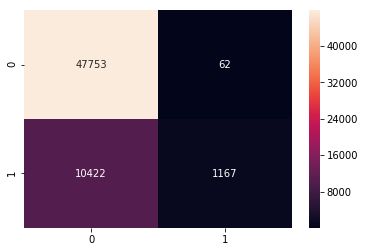

In [36]:
# Report the before-and-afterscores v4 23.02
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_cv, xgb_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_cv, xgb_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_cv, xgb_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_cv, xgb_predictions, beta = 0.5)))

%matplotlib inline
sns.heatmap(confusion_matrix(y_cv, xgb_predictions), annot = True, fmt = '')

In [45]:
submission_Y = xgb_predictions_submission = xgb_model.predict(test_features_final)
print('{}/{} of dealt order'.format(submission_Y.sum(), len(submission_Y) ))

2292/99895 of dealt order


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [147]:
df_submission = test_data.iloc[:,:1].copy()
df_submission['deal_or_not'] = preds_class.astype(int)
df_submission.head()

,order_id,deal_or_not
0,3240332c374b21f9882f899f13b71308,0
1,bf0c0a570b848499180b9dbd49a12d76,0
2,0db30b8d4770f5145d932133e54a35a1,1
3,d3eaffe7c163fabadd8bff4aa28ee1c1,0
4,fefb2b6d55df4474e4826ddac2a97465,0


In [148]:
# export the result
df_submission.to_csv('../submit/xgb_results3.csv', index=False)

### LGBM

In [149]:
def run_lgb(X_train, y_train, X_val, y_val, X_test):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, lgb_train_data, 
                      num_boost_round=5000,
                      valid_sets=[lgb_train_data, lgb_val_data],
                      early_stopping_rounds=100,
                      verbose_eval=500)

    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_submit = model.predict(X_test, num_iteration=model.best_iteration)

    print(f"LGBM: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [ ]:
lgb_res = run_lgb(X_train, y_train, X_cv, y_cv, test_features_final)

### Catboost 

In [45]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2, learning_rate=1, depth=2, loss_function='Logloss')
# Fit model
model.fit(X_train, y_train)
# Get predicted classes
preds_class = model.predict(test_features_final)
# Get predicted probabilities for each class

preds_raw = model.predict(test_features_final, prediction_type='RawFormulaVal')

0:	learn: 0.4679904	total: 105ms	remaining: 105ms
1:	learn: 0.4622041	total: 145ms	remaining: 0us


In [58]:
y_cv_hat = model.predict(X_cv).astype(int)


Optimized Model
------
Final accuracy score on the testing data: 0.8226
Final precision score on the testing data: 0.9721
Final recall score on the testing data: 0.0933
Final F-score on the testing data: 0.3370


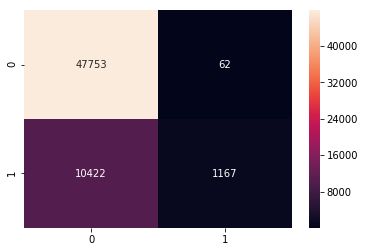

In [59]:
# Report the before-and-afterscores v5
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_cv, y_cv_hat)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_cv, y_cv_hat)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_cv, y_cv_hat)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_cv, y_cv_hat, beta = 0.5)))

%matplotlib inline
sns.heatmap(confusion_matrix(y_cv, xgb_predictions), annot = True, fmt = '')

In [52]:
df_submission2 = test_data.iloc[:,:1].copy()
df_submission2['deal_or_not'] = preds_class.astype(int)
df_submission2.head()

,order_id,deal_or_not
0,3240332c374b21f9882f899f13b71308,0
1,bf0c0a570b848499180b9dbd49a12d76,0
2,0db30b8d4770f5145d932133e54a35a1,1
3,d3eaffe7c163fabadd8bff4aa28ee1c1,0
4,fefb2b6d55df4474e4826ddac2a97465,0


In [54]:
# export the result
df_submission2.to_csv('../submit/cat_results.csv', index=False)